In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

y = np.where(y == 0, -1, 1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
import numpy as np

X_train_bias = np.hstack([X_train_scaled, np.ones((X_train_scaled.shape[0], 1))])
X_test_bias = np.hstack([X_test_scaled, np.ones((X_test_scaled.shape[0], 1))])
X_train_bias

array([[-1.44075296, -0.43531947, -1.36208497, ...,  2.09724217,
         1.88645014,  1.        ],
       [ 1.97409619,  1.73302577,  2.09167167, ...,  1.89116053,
         2.49783848,  1.        ],
       [-1.39998202, -1.24962228, -1.34520926, ...,  0.59760192,
         0.0578942 ,  1.        ],
       ...,
       [ 0.04880192, -0.55500086, -0.06512547, ..., -0.70863864,
        -1.27145475,  1.        ],
       [-0.03896885,  0.10207345, -0.03137406, ...,  0.43432185,
         1.21336207,  1.        ],
       [-0.54860557,  0.31327591, -0.60350155, ..., -0.3345212 ,
        -0.84628745,  1.        ]], shape=(455, 31))

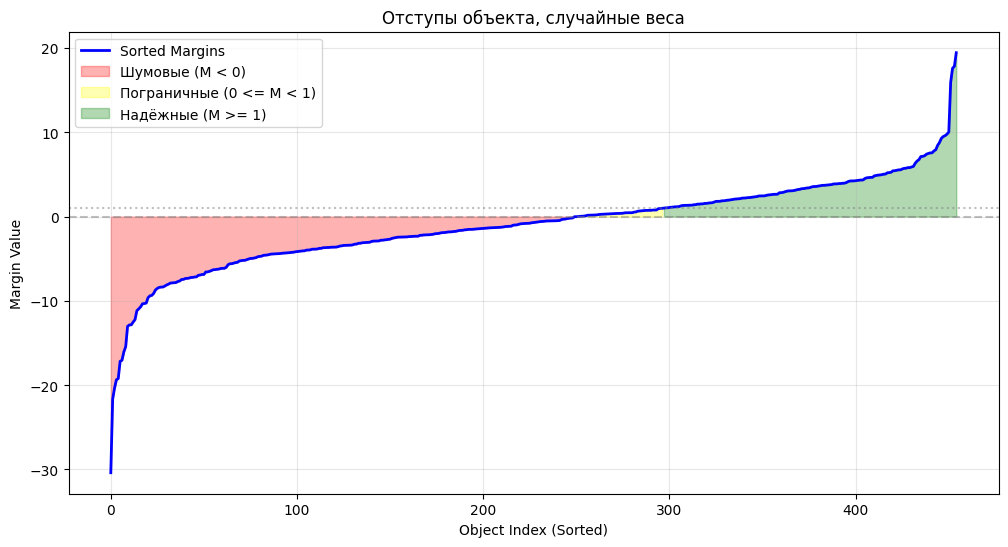

In [10]:
from utils import plot_margins

np.random.seed(42)
w_random = np.random.randn(X_train_bias.shape[1])

plot_margins(X_train_bias, y_train, w_random, "Отступы объекта, случайные веса")

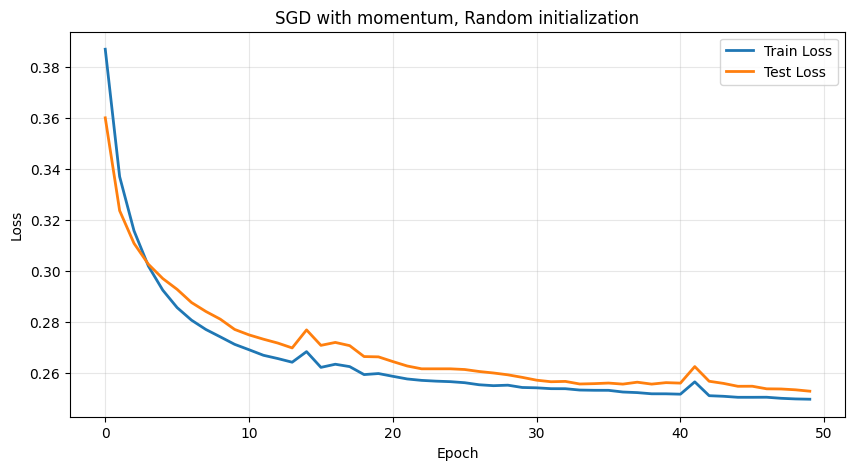

In [ ]:
from lincls import LinearClassifier
from utils import plot_loss

np.random.seed(42)
model = LinearClassifier(
    learning_rate=0.003, momentum=0.3, lambda_reg=0.1, n_epochs=50, batch_size=32
)
model.fit(
    X_train_bias,
    y_train,
    X_val=X_test_bias,
    y_val=y_test,
    method="sgd",
    init="random",
    presentation="random",
)

plot_loss(model, "SGD with momentum, Random initialization")

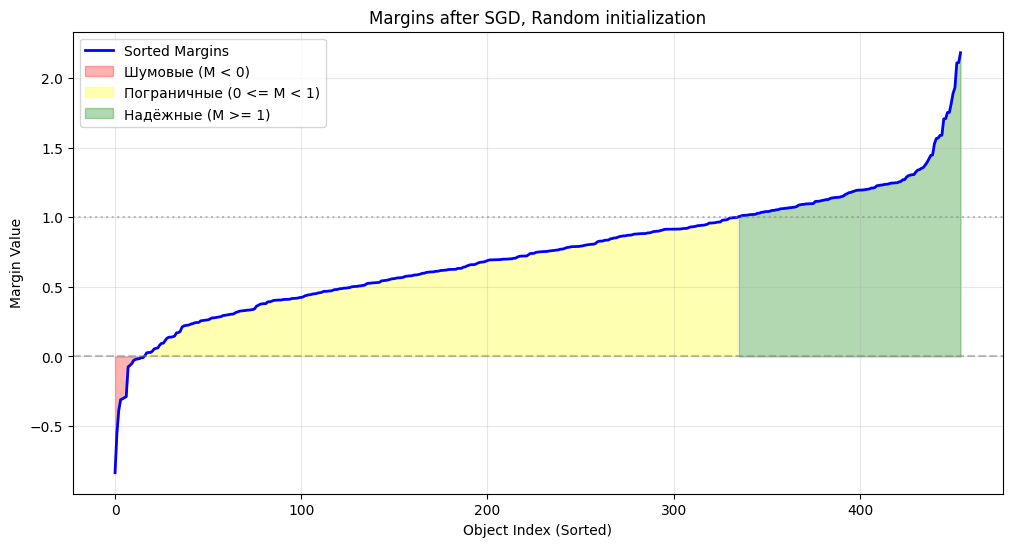

In [12]:
plot_margins(X_train_bias, y_train, model.w, "Margins after SGD, Random initialization")

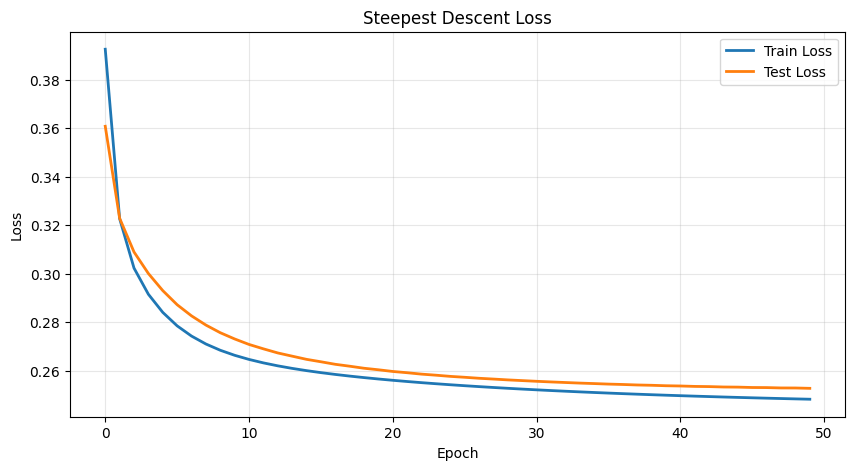

In [ ]:
model_steepest = LinearClassifier(n_epochs=50)
model_steepest.fit(X_train_bias, y_train, X_test_bias, y_test, method="steepest")

plot_loss(model_steepest, "Steepest Descent Loss")

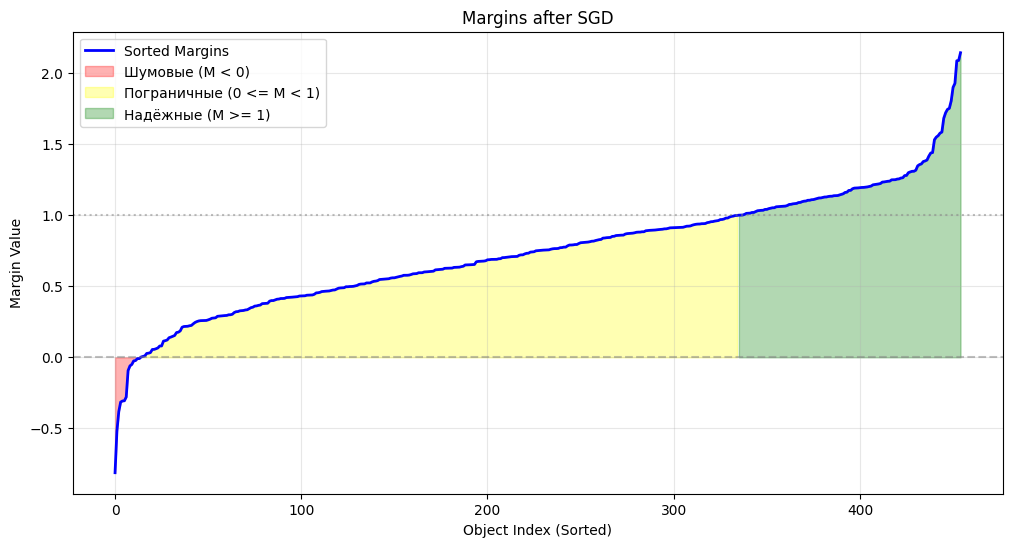

In [14]:
plot_margins(X_train_bias, y_train, model_steepest.w, "Margins after SGD")

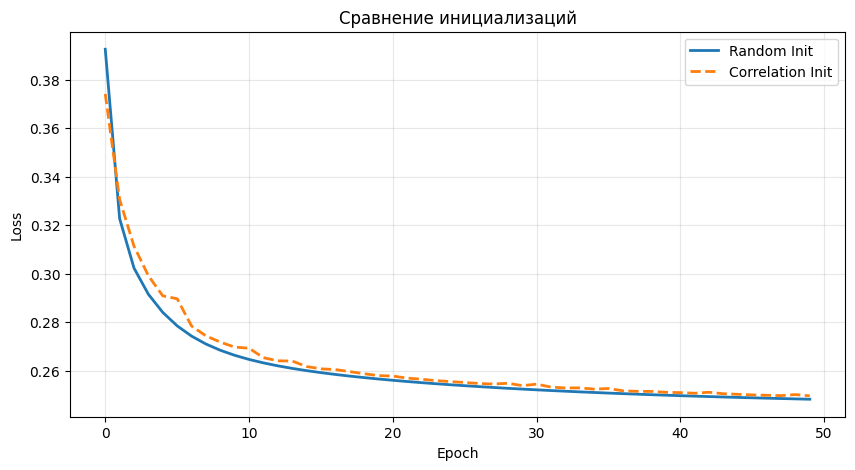

In [ ]:
import matplotlib.pyplot as plt

model_steepest_corr = LinearClassifier(
    learning_rate=0.003, momentum=0.3, lambda_reg=0.1, n_epochs=50, batch_size=32
)
model_steepest_corr.fit(
    X_train_bias, y_train, X_test_bias, y_test, method="sgd", init="correlation"
)

plt.figure(figsize=(10, 5))
plt.plot(model_steepest.loss_history, label="Random Init", linewidth=2)
plt.plot(
    model_steepest_corr.loss_history,
    label="Correlation Init",
    linewidth=2,
    linestyle="--",
)
plt.title("Сравнение инициализаций")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

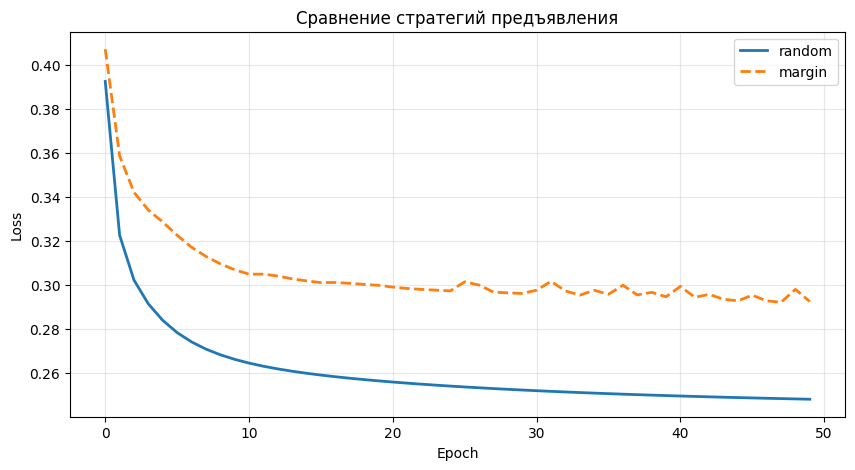

In [ ]:
from utils import plot_comparision

np.random.seed(42)

model_margin = LinearClassifier(
    learning_rate=0.003, momentum=0.3, lambda_reg=0.1, n_epochs=50, batch_size=32
)
model_margin.fit(X_train_bias, y_train, X_test_bias, y_test, "sgd", "random", "margin")

plot_comparision(model_steepest, model_margin, "random", "margin")

Run 1: loss=0.2516, accuracy=0.9561
Run 2: loss=0.2497, accuracy=0.9737
Run 3: loss=0.2496, accuracy=0.9561
Run 4: loss=0.2492, accuracy=0.9561
Run 5: loss=0.2529, accuracy=0.9474
Run 6: loss=0.2493, accuracy=0.9737
Run 7: loss=0.2495, accuracy=0.9561
Run 8: loss=0.2499, accuracy=0.9474
Run 9: loss=0.2495, accuracy=0.9737
Run 10: loss=0.2494, accuracy=0.9649

Best Loss after multistart: 0.2492
Best Model Accuracy: 0.9561


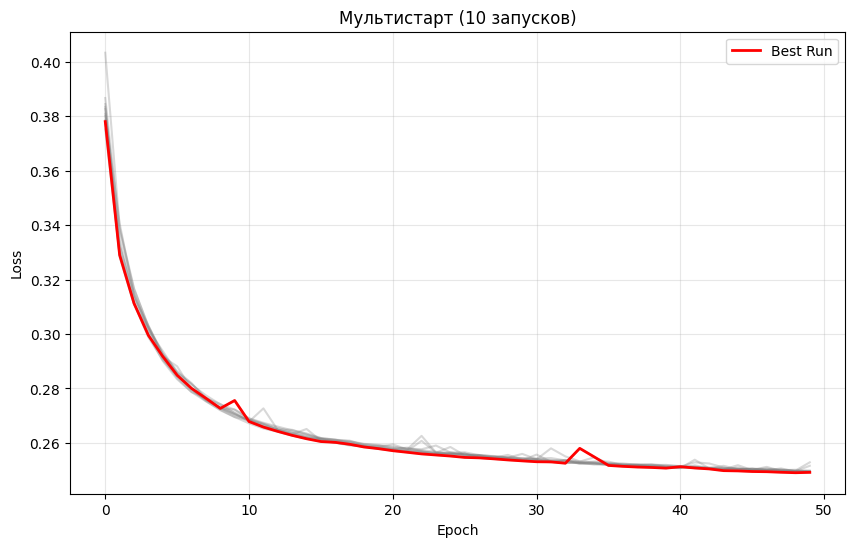

In [18]:
from utils import plot_multistart

np.random.seed(42)

best_model = None
best_loss = float("inf")
n_starts = 10

loss_histories = []

for i in range(n_starts):
    np.random.seed(100 + i)
    model = LinearClassifier(
        learning_rate=0.003, momentum=0.3, lambda_reg=0.1, n_epochs=50, batch_size=32
    )
    model.fit(X_train_bias, y_train, X_test_bias, y_test, "sgd", "random")
    last_loss = model.loss_history[-1]
    loss_histories.append(model.loss_history)

    if last_loss < best_loss:
        best_loss = last_loss
        best_model = model

    print(
        f"Run {i + 1}: loss={last_loss:.4f}, accuracy={model.score(X_test_bias, y_test):.4f}"
    )

print(f"\nBest Loss after multistart: {best_loss:.4f}")
print(f"Best Model Accuracy: {best_model.score(X_test_bias, y_test):.4f}")

plot_multistart(loss_histories, best_model)

In [ ]:
from sklearn.linear_model import SGDClassifier

sklearn_model = SGDClassifier(
    loss="squared_error",
    alpha=0.1,
    learning_rate="constant",
    eta0=0.003,
    tol=1e-4,
    random_state=42,
    validation_fraction=0.2,
    n_iter_no_change=10,
)

sklearn_model.fit(X_train_scaled, y_train)

print(f"SKLearn:           {sklearn_model.score(X_test_scaled, y_test):.4f}")
print(f"\nНаша реализация:         {best_model.score(X_test_bias, y_test):.4f}")

SKLearn:           0.9561

Наша реализация:         0.9561
